In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../..')

%matplotlib inline
sns.set()

In [3]:
import glob

In [54]:
idx = 2

In [55]:
no_kaf = glob.glob('../../logs/nasdaq.csv/darnn_0_0/*/*')[idx]
kaf_time = glob.glob('../../logs/nasdaq.csv/darnn_0_1/*/*')[idx]
kaf_input = glob.glob('../../logs/nasdaq.csv/darnn_1_0/*/*')[idx]
kaf_dual = glob.glob('../../logs/nasdaq.csv/darnn_1_1/*/*')[idx]

In [56]:
df_no_kaf = pd.read_csv(no_kaf + '/train/results.csv')
df_kaf_time = pd.read_csv(kaf_time + '/train/results.csv')
df_kaf_input = pd.read_csv(kaf_input + '/train/results.csv')
df_kaf_dual = pd.read_csv(kaf_dual + '/train/results.csv')

In [57]:
def smooth(x,w=0.5):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

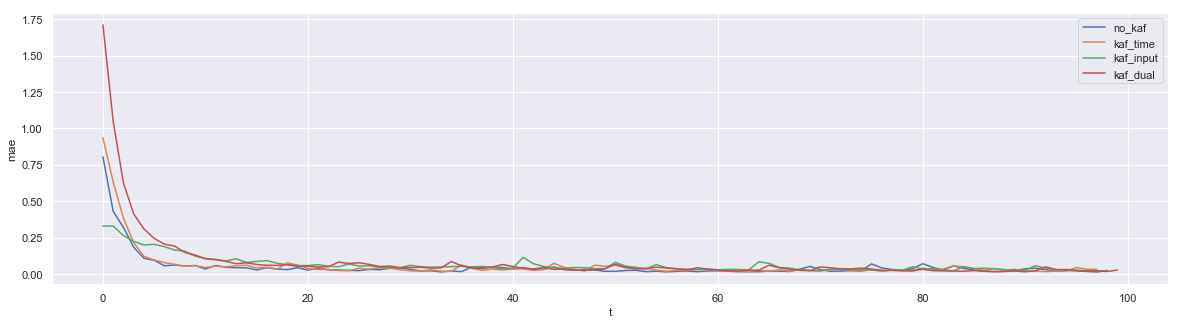

In [58]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['no_kaf','kaf_time','kaf_input', 'kaf_dual'])

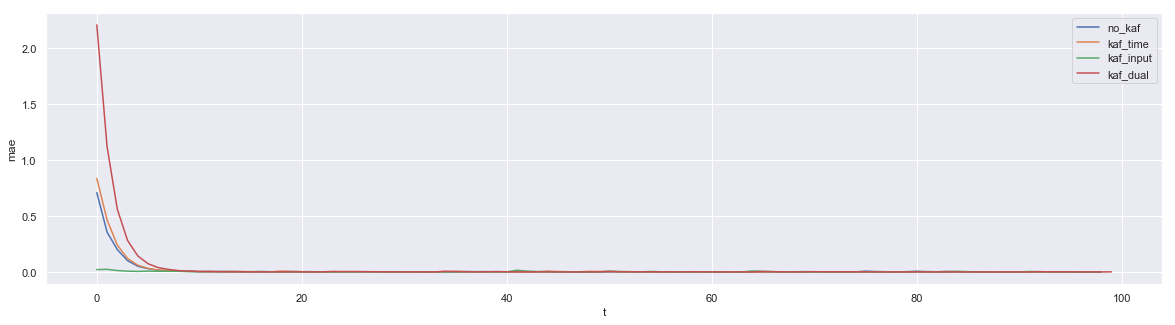

In [59]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_no_kaf.mse.values))
ax.plot(smooth(df_kaf_time.mse.values))
ax.plot(smooth(df_kaf_input.mse.values))
ax.plot(smooth(df_kaf_dual.mse.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['no_kaf',
#             'dense', 'seq2seq',
            'kaf_time','kaf_input', 'kaf_dual'])

In [60]:
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))

In [61]:
# no reg
rows = ['no_kaf','kaf_time','kaf_input', 'kaf_dual']

table = pd.concat([df_no_kaf.mean(axis=0), 
                   df_kaf_time.mean(axis=0), 
                   df_kaf_input.mean(axis=0), 
                   df_kaf_dual.mean(axis=0)], axis=1)
table.columns = rows

table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
no_kaf,0.040253,0.000000,6.539626,0.009370,0.040253,0.080729,0.040253,123.358428
kaf_time,0.047012,0.001611,5.443445,0.011620,0.045402,0.078410,0.045402,92.331248
kaf_input,0.060470,0.027505,4.760851,0.002489,0.032966,0.053918,0.032966,16.531373
kaf_dual,0.069859,0.026342,3.904910,0.023947,0.043516,0.066624,0.043516,18.087328


In [42]:
header = table.index.tolist()

In [43]:
df_no_kaf = pd.read_csv(no_kaf + '/test/results.csv', names=header)
# df_dense = pd.read_csv(dense + '/test/results.csv', names=header)
# df_seq2seq = pd.read_csv(seq2seq + '/test/results.csv', names=header)
df_kaf_time = pd.read_csv(kaf_time + '/test/results.csv', names=header)
df_kaf_input = pd.read_csv(kaf_input + '/test/results.csv', names=header)
df_kaf_dual = pd.read_csv(kaf_dual+ '/test/results.csv', names=header)

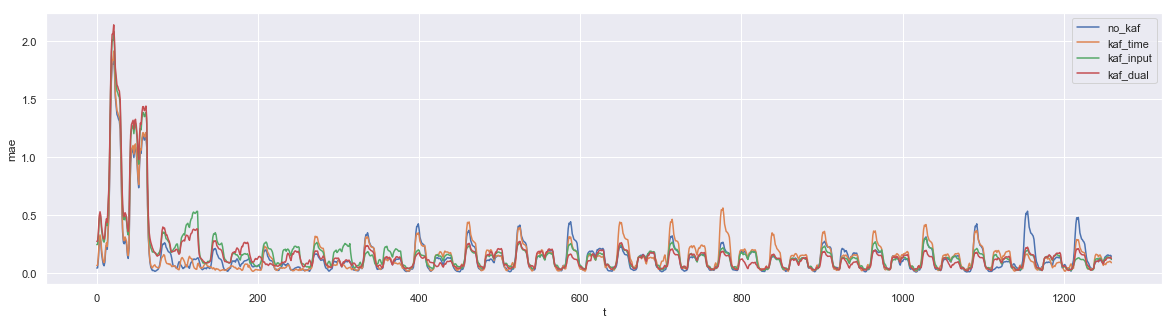

In [44]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_no_kaf.loss.values))
# ax.plot(smooth(df_dense.loss.values))
# ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [45]:
# there is no regularization in no_kaf, dense, se2see the value in rmse is the smape!
table = pd.concat([df_no_kaf.mean(axis=0), 
#                    df_dense.mean(axis=0),
#                    df_seq2seq.mean(axis=0),
                   df_kaf_time.mean(axis=0), 
                   df_kaf_input.mean(axis=0), 
                   df_kaf_dual.mean(axis=0)], axis=1)
table.columns = rows

In [46]:
# no reg
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
no_kaf,0.151364,5.208815,0.074514,0.151364,0.186009,0.151364,56.529872,NaN
kaf_time,0.160400,0.002256,8.026850,0.078929,0.158145,0.198606,0.158145,79.883349
kaf_input,0.176605,0.034608,6.846134,0.068784,0.141997,0.179551,0.141997,44.559507
kaf_dual,0.165533,0.037469,6.554569,0.065568,0.128064,0.165579,0.128064,49.370201


In [47]:
def last_path(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    idx = max(idxs)
    paths
    return base_path + '/report/' + ''.join([str(idx), '_', 'report.csv'])

In [48]:
df_no_kaf = pd.read_csv(last_path(no_kaf), index_col=0)
# df_dense = pd.read_csv(last_path(dense), index_col=0)
# df_seq2seq = pd.read_csv(last_path(seq2seq), index_col=0)
df_kaf_time = pd.read_csv(last_path(kaf_time), index_col=0)
df_kaf_input = pd.read_csv(last_path(kaf_input), index_col=0)
df_kaf_dual = pd.read_csv(last_path(kaf_dual), index_col=0)

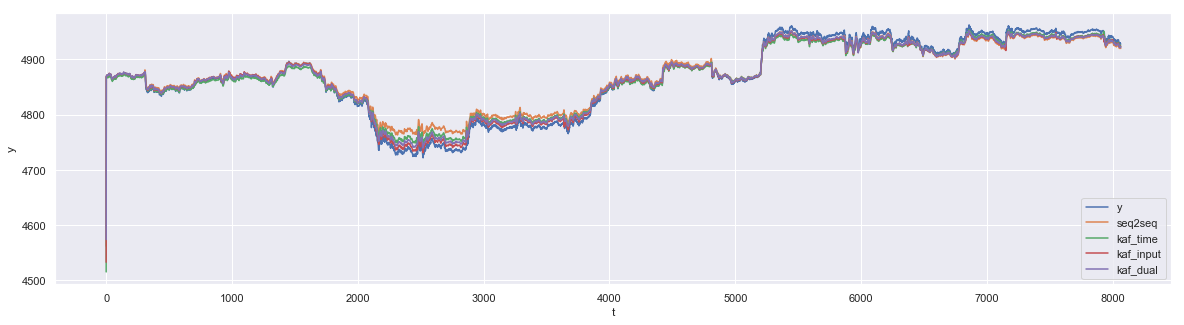

In [49]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df_no_kaf.y.values)
ax.plot(df_no_kaf.y_hat.values)
# ax.plot(df_dense.y_hat.values)
# ax.plot(df_seq2seq.y_hat.values)
ax.plot(df_kaf_time.y_hat.values)
ax.plot(df_kaf_input.y_hat.values)
ax.plot(df_kaf_dual.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y',
#             'no_kaf','dense', 
            'seq2seq','kaf_time','kaf_input', 'kaf_dual'])

In [50]:
from ntsa.utils.misc import regr_metrics

In [51]:
y = df_no_kaf.y.values
y_no_kaf = df_no_kaf.y_hat.values
# y_dense = df_dense.y_hat.values
# y_seq2seq = df_seq2seq.y_hat.values
y_kaf_time = df_kaf_time.y_hat.values
y_kaf_input = df_kaf_input.y_hat.values
y_kaf_dual = df_kaf_dual.y_hat.values

In [52]:
metrics = [
list(regr_metrics(y, y_no_kaf).values()),
# list(regr_metrics(y, y_dense).values()),
# list(regr_metrics(y, y_seq2seq).values()),
list(regr_metrics(y, y_kaf_time).values()),
list(regr_metrics(y, y_kaf_input).values()),
list(regr_metrics(y, y_kaf_dual).values())
]

In [53]:
# no reg
pd.DataFrame(np.array(metrics), index=['no_kaf',
#                                        'dense',
#                                        'seq2seq',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape', 'mape'])

,mse,mae,smape,mape
no_kaf,190.078321,9.970078,0.002063,0.206024
time,101.362106,7.369221,0.001521,0.152036
input,53.464018,5.401353,0.001109,0.110988
dual,64.230617,6.090048,0.001255,0.125534
